In [37]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.neighbors import BallTree

In [38]:
hotspots = gpd.read_file("./data_2024/hotspots/fire_archive_M-C61_629919.shp")
perimeter = gpd.read_file("./data_2024/perimeter/cc_apt_buf.shp")

# print(hotspots.head(3))
# print(perimeter.head(3))


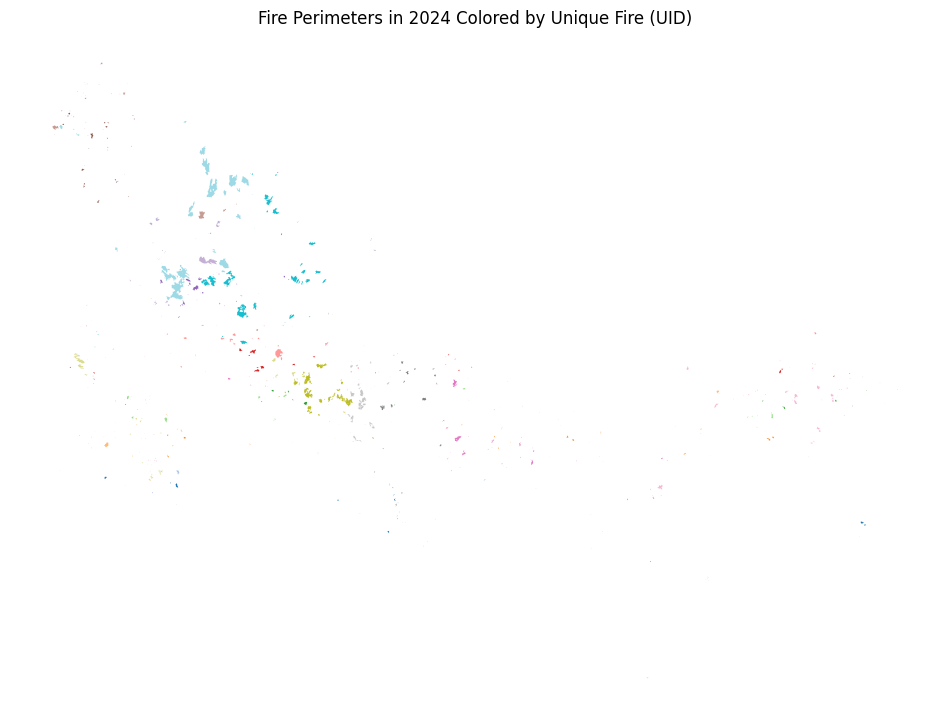

In [39]:
# Set + Match CRS for both files
if hotspots.crs is None:
    hotspots.set_crs(epsg=4326, inplace=True)  # WGS84 lat/lon

if perimeter.crs is None:
    perimeter.set_crs(epsg=3978, inplace=True)  # NAD_1983_Canada_Atlas_Lambert

hotspots = hotspots.to_crs(perimeter.crs)

# Check intersections
hotspots_with_perimeter = gpd.sjoin(hotspots, perimeter, how="inner", predicate="intersects")

# print(hotspots_with_perimeter.head())

# Count number of fire points per polygon UID
counts = hotspots_with_perimeter.groupby("UID").size().reset_index(name="hotspot_count")

# Join counts back to cc dataset
perimeter_with_counts = perimeter.merge(counts, on="UID", how="left")
perimeter_with_counts["hotspot_count"] = perimeter_with_counts["hotspot_count"].fillna(0).astype(int)

# Plot fire perimeters colored by UID
fig, ax = plt.subplots(figsize=(12, 12))
perimeter_with_counts.plot(
    ax=ax,
    column="UID",
    categorical=True,
    legend=False,
    cmap="tab20"
)

ax.set_title("Fire Perimeters in 2024 Colored by Unique Fire (UID)")
ax.axis("off")
plt.show()

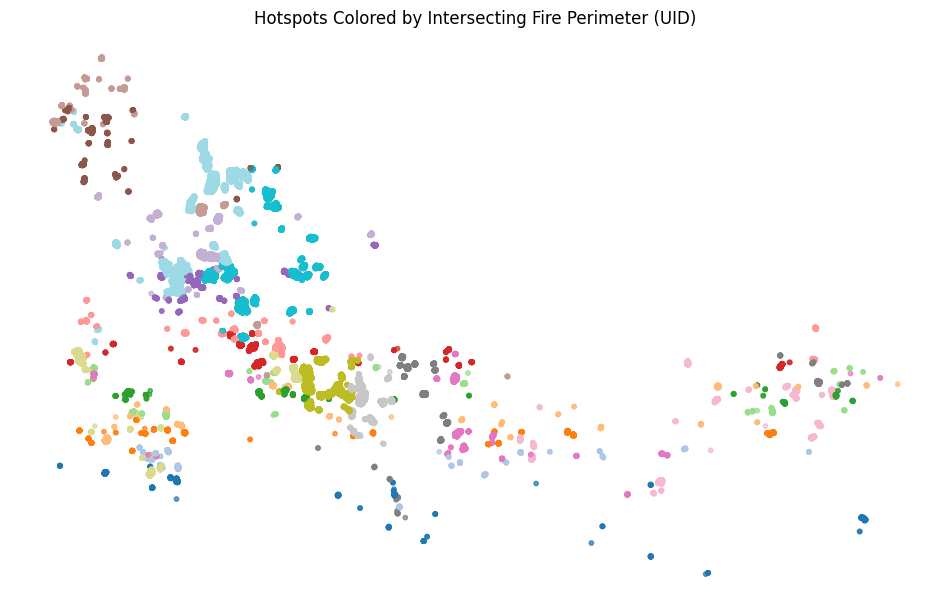

In [40]:
# Plot hotspot points, colored by respective fire groups
fig, ax = plt.subplots(figsize=(12, 12))

hotspots_with_perimeter.plot(
    ax=ax,
    column="UID",
    categorical=True,
    legend=False,
    cmap="tab20",
    markersize=10,
    alpha=0.7
)

ax.set_title("Hotspots Colored by Intersecting Fire Perimeter (UID)")
ax.axis("off")

plt.show()

In [41]:
# Load data
fire = gpd.read_file("data_2024/hotspots/fire_archive_M-C61_629919.shp")
fire['ACQ_DATE'] = pd.to_datetime(fire['ACQ_DATE'])
fire['day'] = (fire['ACQ_DATE'] - fire['ACQ_DATE'].min()).dt.days

# Sort data by date
fire = fire.sort_values('ACQ_DATE')

# Prepare training data by pairing points day t with points day t+1 nearby (within 5km)
def pair_points_next_day(df, max_distance_km=5):
    earth_radius_km = 6371.0
    pairs = []

    # Precompute radians coords for all points
    coords_rad = np.radians(df[['LATITUDE', 'LONGITUDE']].values)
    
    # Group points by date
    grouped = df.groupby('ACQ_DATE')
    dates = sorted(df['ACQ_DATE'].unique())
    
    for i in range(len(dates)-1):
        day_t = dates[i]
        day_t1 = dates[i+1]
        
        pts_t = df[df['ACQ_DATE'] == day_t]
        pts_t1 = df[df['ACQ_DATE'] == day_t1]
        
        if pts_t.empty or pts_t1.empty:
            continue
        
        tree_t1 = BallTree(np.radians(pts_t1[['LATITUDE', 'LONGITUDE']].values), metric='haversine')
        
        for idx, row in pts_t.iterrows():
            point_rad = np.radians([[row['LATITUDE'], row['LONGITUDE']]])
            radius_rad = max_distance_km / earth_radius_km
            ind = tree_t1.query_radius(point_rad, r=radius_rad)
            neighbors_idx = ind[0]
            
            # If multiple neighbors next day, take closest
            if len(neighbors_idx) > 0:
                neighbors = pts_t1.iloc[neighbors_idx]
                dists = BallTree(np.radians(neighbors[['LATITUDE', 'LONGITUDE']])).query(point_rad, k=len(neighbors))[0][0]
                closest_idx = neighbors_idx[np.argmin(dists)]
                closest_point = pts_t1.iloc[closest_idx]
                
                pairs.append({
                    'lat_t': row['LATITUDE'],
                    'lon_t': row['LONGITUDE'],
                    'frp_t': row['FRP'],
                    'day_t': (day_t - df['ACQ_DATE'].min()).days,
                    'lat_t1': closest_point['LATITUDE'],
                    'lon_t1': closest_point['LONGITUDE']
                })
    return pd.DataFrame(pairs)

train_df = pair_points_next_day(fire)

# Features and targets
X = train_df[['lat_t', 'lon_t', 'frp_t', 'day_t']]
y_lat = train_df['lat_t1']
y_lon = train_df['lon_t1']

# Train/test split
X_train, X_test, y_lat_train, y_lat_test, y_lon_train, y_lon_test = train_test_split(
    X, y_lat, y_lon, test_size=0.2, random_state=42)

# Train regressors
model_lat = RandomForestRegressor(n_estimators=100, random_state=42)
model_lon = RandomForestRegressor(n_estimators=100, random_state=42)

model_lat.fit(X_train, y_lat_train)
model_lon.fit(X_train, y_lon_train)

# Predict next day locations from test set
lat_pred = model_lat.predict(X_test)
lon_pred = model_lon.predict(X_test)

# Show example predictions
for i in range(5):
    print(f"Current location: ({X_test.iloc[i]['lat_t']:.4f}, {X_test.iloc[i]['lon_t']:.4f})")
    print(f"Actual next day location: ({y_lat_test.iloc[i]:.4f}, {y_lon_test.iloc[i]:.4f})")
    print(f"Predicted next day location: ({lat_pred[i]:.4f}, {lon_pred[i]:.4f})\n")

Current location: (58.7506, -114.8503)
Actual next day location: (58.7097, -114.8500)
Predicted next day location: (58.7450, -114.8543)

Current location: (54.8395, -103.1284)
Actual next day location: (54.8299, -103.1868)
Predicted next day location: (54.8276, -103.1797)

Current location: (65.2529, -124.9639)
Actual next day location: (65.2461, -125.0024)
Predicted next day location: (65.2461, -125.0028)

Current location: (55.9985, -107.4630)
Actual next day location: (55.9923, -107.5321)
Predicted next day location: (55.9893, -107.5285)

Current location: (58.7993, -114.6196)
Actual next day location: (58.7761, -114.6479)
Predicted next day location: (58.7781, -114.6509)



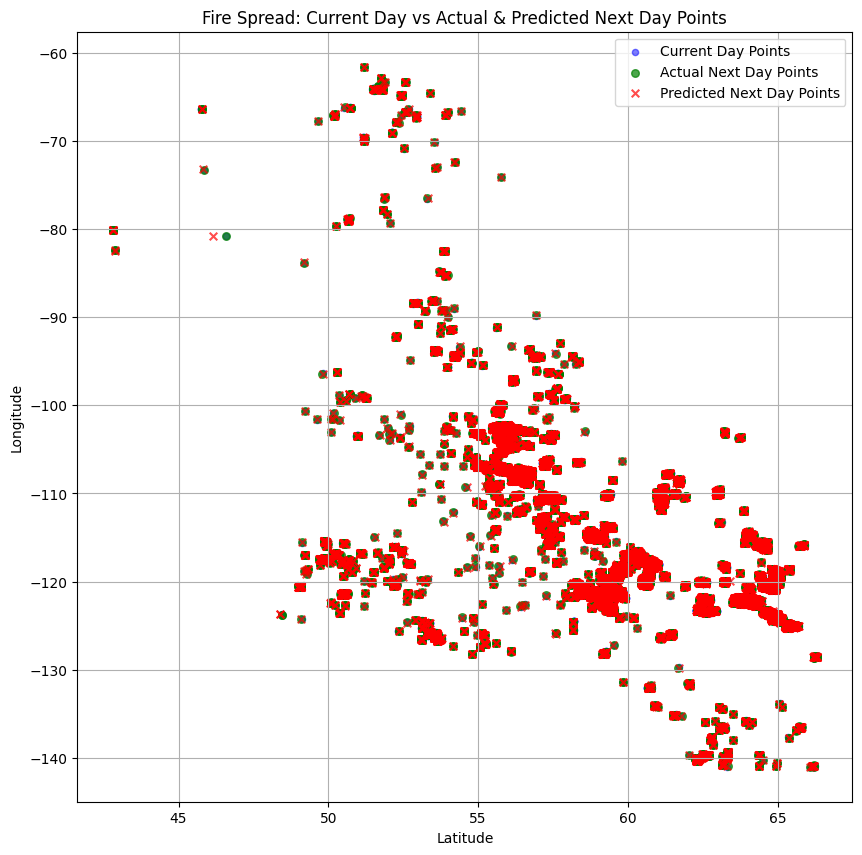

In [42]:
# Plot actual vs predicted next day locations
plt.figure(figsize=(10, 10))

# Plot current day points (X_test locations)
plt.scatter(X_test['lat_t'], X_test['lon_t'], c='blue', label='Current Day Points', alpha=0.5, s=20)

# Plot actual next day points
plt.scatter(y_lat_test, y_lon_test, c='green', label='Actual Next Day Points', alpha=0.7, s=30)

# Plot predicted next day points
plt.scatter(lat_pred, lon_pred, c='red', label='Predicted Next Day Points', alpha=0.7, s=30, marker='x')

plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Fire Spread: Current Day vs Actual & Predicted Next Day Points')
plt.legend()
plt.grid(True)
plt.show()